In [1]:
# !pip install pyyaml==5.1
# !pip install "git+https://github.com/facebookresearch/detectron2.git"

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  1.10 ; cuda:  1.10.1
detectron2: 0.6


'nvcc' is not recognized as an internal or external command,
operable program or batch file.


Import Detectron

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from livecell_tracker.segment.detectron_utils import gen_cfg

In [4]:
from detectron2.data.datasets import register_coco_instances

train_data_path = r"""."""
train_json_path = r"""D:\xing-vimentin-dic-pipeline\src\livecell_dev\notebooks\labelme2coco_test_output_8bit_png\train.json"""

val_data_path = r"""."""
val_json_path = r"""D:\xing-vimentin-dic-pipeline\src\livecell_dev\notebooks\labelme2coco_test_output_8bit_png\val.json"""
register_coco_instances("deepfashion_train", {}, train_json_path, train_data_path)
register_coco_instances("deepfashion_val", {}, val_json_path, val_data_path)

## Detectron config

In [5]:
output_dir = "./detectron_run1_output/"

    
cfg = gen_cfg()

In [6]:
import torch
print(torch.version)
print(torch.cuda.is_available())

<module 'torch.version' from 'c:\\Users\\dummy\\Anaconda3\\envs\\cv-general\\lib\\site-packages\\torch\\version.py'>
True


In [7]:
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
# trainer.train()

[09/09 11:54:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (14, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (14,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (52, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (52,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (13, 256, 1, 

In [9]:
cfg = gen_cfg()
cfg.OUTPUT_DIR = output_dir
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("deepfashion_val", )
predictor = DefaultPredictor(cfg)

[09/09 11:55:14 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import glob
from pathlib import Path
from PIL import Image, ImageSequence
from tqdm import tqdm
import os
import os.path
import livecell_tracker.segment.datasets

dir_path = Path('D:\\xing-vimentin-dic-pipeline\\src\\livecell_dev\\cxa-data\\june_2022_data_8bit_png\day0_Notreat_Group1_wellA1_RI_MIP_stitched')
# imgs = livecell_tracker.segment.datasets.LiveCellImageDataset(dir_path, ext="tif")
imgs = livecell_tracker.segment.datasets.LiveCellImageDataset(dir_path, ext="png")

120 png img file paths loaded: 


In [11]:
raw_img1 = imgs[50][:, :, np.newaxis]
# raw_img1 = normalize_img_by_zscore(raw_img1)

In [12]:
def detectron_predict_single_img(img):
    outputs = predictor(img)
    return outputs

def detectron_predict_and_visualize_img(img):
    outputs = detectron_predict_single_img(img)
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    figure = plt.figure(figsize=(20, 20), dpi=80)
    plt.imshow(v.get_image()[:, :, ::-1])

In [13]:
detectron_predict_single_img(raw_img1)

c:\Users\dummy\Anaconda3\envs\cv-general\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'instances': Instances(num_instances=23, image_height=2408, image_width=2408, fields=[pred_boxes: Boxes(tensor([[ 137.1965,  184.5702,  364.5423,  392.2824],
         [1353.3088, 1844.9601, 1417.9846, 1903.8168],
         [1146.8167, 1287.4353, 1426.9065, 1571.7413],
         [ 374.7235,  307.3349,  455.3343,  396.2485],
         [ 325.6589,  103.4153,  630.4565,  607.9745],
         [1451.1470, 1766.3262, 1626.6526, 1994.6321],
         [2050.3140,  767.4607, 2228.0532,  900.9001],
         [1240.5441, 1759.7769, 1528.4253, 1998.4899],
         [1282.2721,   21.0861, 1500.6417,  281.0587],
         [1375.4825,   70.5185, 1429.4940,  130.1831],
         [1486.1808, 1847.5620, 1536.0449, 1920.6860],
         [2076.2000,  809.6678, 2327.2717, 1133.0012],
         [1261.8845, 1401.1128, 1324.4581, 1465.4801],
         [ 134.3632,  304.4207,  372.2760,  588.9817],
         [1299.1072,   78.2037, 1350.3085,  173.7201],
         [1240.1167,   35.2193, 1373.8839,  230.8056],
         [2128.5

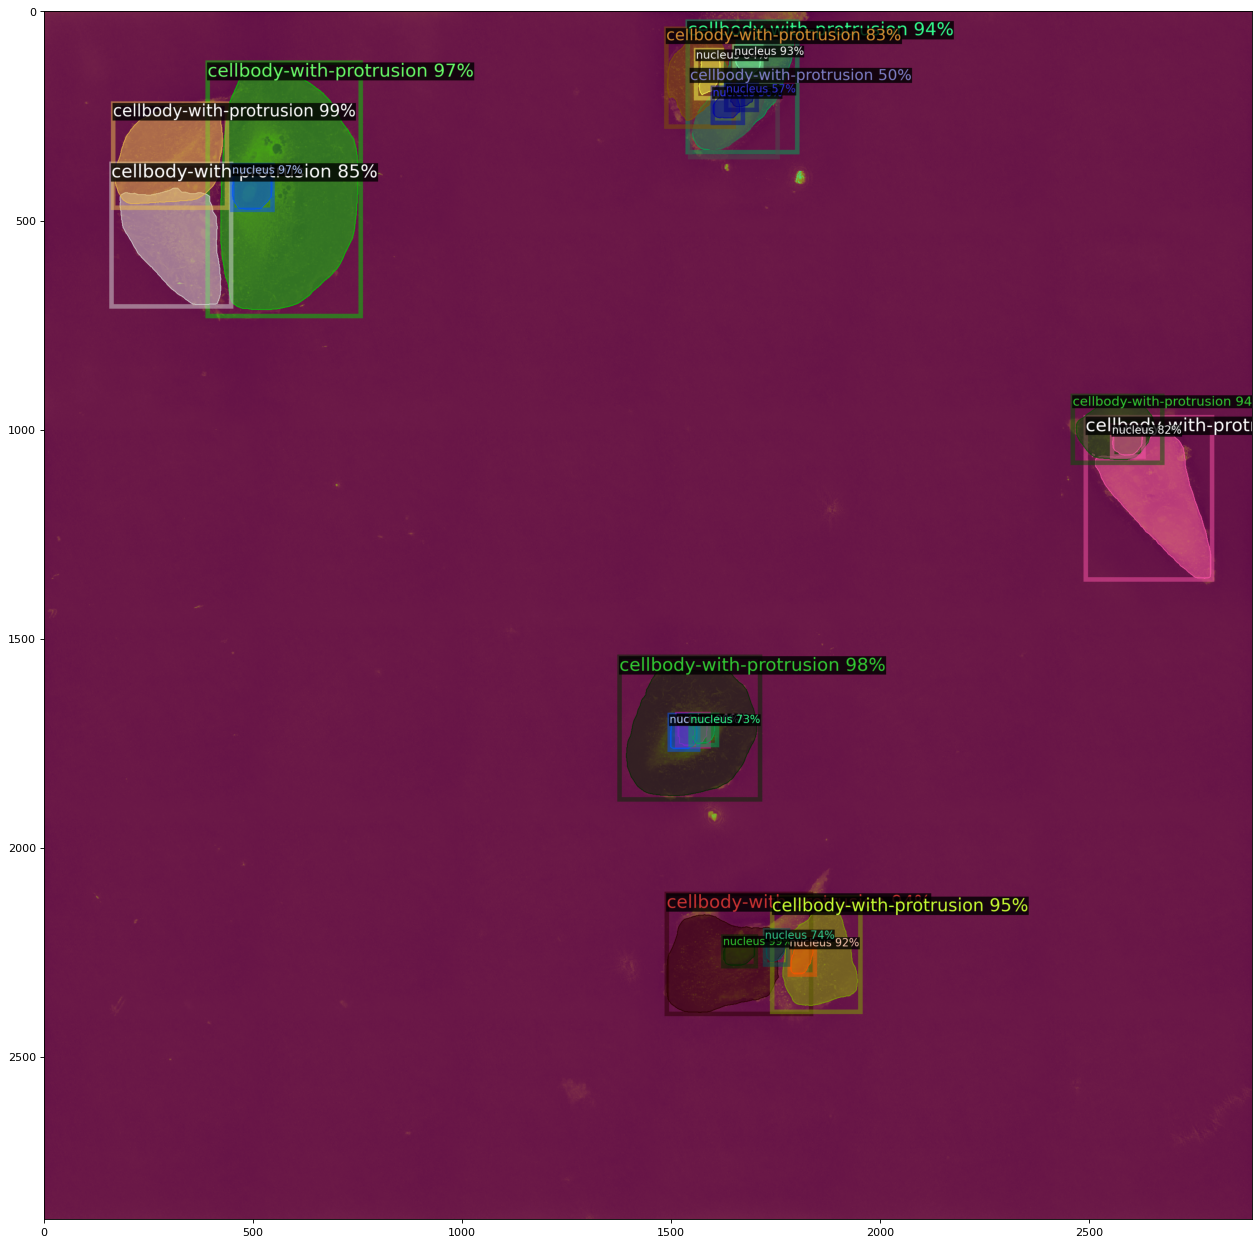

In [14]:
detectron_visualize_img(raw_img1)

In [ ]:
raw_img1[:5, 0]

array([[1.3398427],
       [1.3400884],
       [1.3395792],
       [1.340378 ],
       [1.3398261]], dtype=float32)